In [1]:
import numba as nb
import torch
import numpy as np 
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
import torch.optim as optim
os.chdir('/home/baly/projects/sopt_shape_submit')
from lib.library import *
from lib.lib_ot import *
from lib.sliced_opt import *
from lib.lib_shape import *
from lib.cpd import *
from lib.icp_ffd import *


# load the female/male/neutral data and add noise 

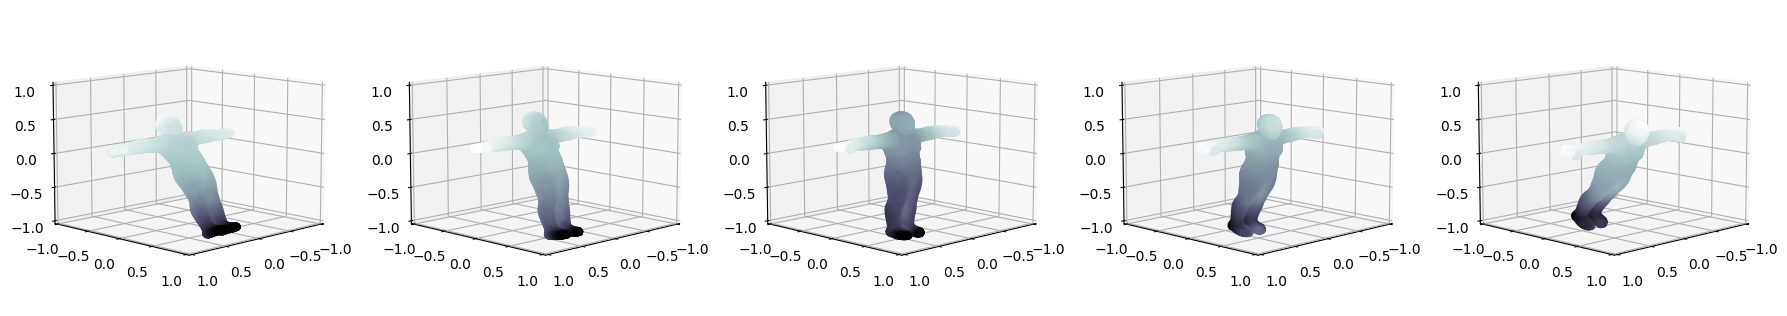

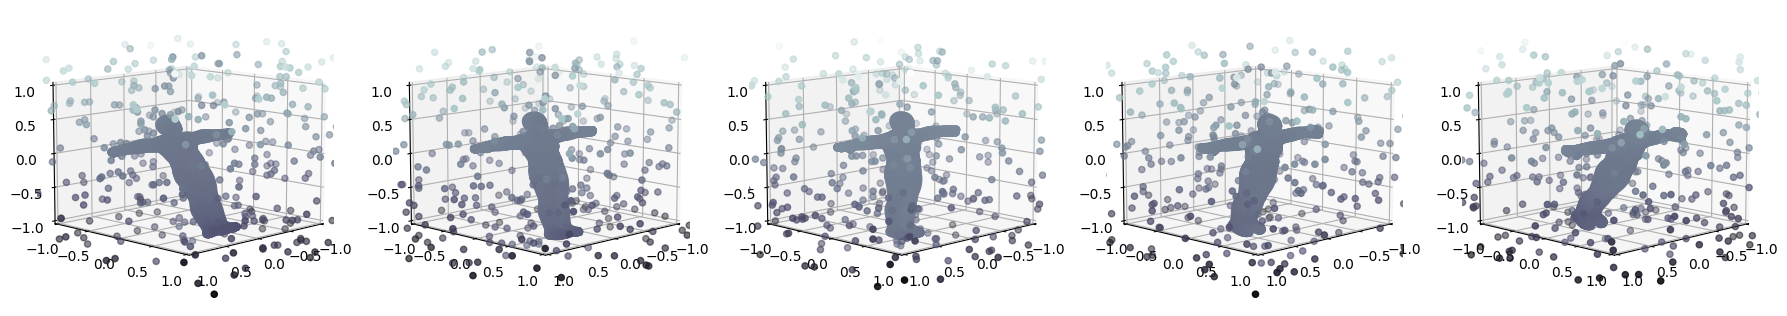

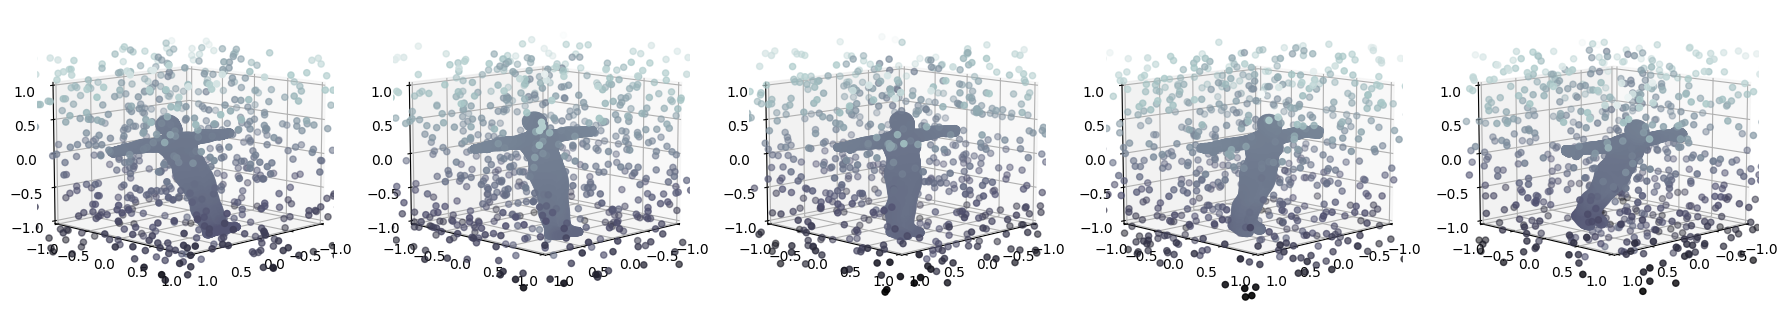

In [27]:

label='neutral' 
# other choices are "female", "male", "neutral"
data_list=torch.load('data/'+label+'_list.pt')
data_all={}

X=data_list[0] 
Y=data_list[-1]
n,d=X.shape


fig = plt.figure(figsize=(2*800/72,800/72))    
for n,i in enumerate(np.linspace(-.5,.5,5)):
    ax = fig.add_subplot(1, 5, n+1, projection='3d')
    data=data_list[n]
    x=data[:,0]
    y=data[:,1]
    z=data[:,2]
    ax.scatter3D(x, z, y, c=y*np.sqrt(x**2+z**2), cmap='bone')
    ax.set_xlim([-1,1]);ax.set_ylim([-1,1]);ax.set_zlim([-1,1])
    ax.view_init(10, 45)
plt.show()
data_all['0']=data_list


# generate 5% noisy data
n,d=X.shape
data_listY1=[]
eta=0.05
n_noise=int(n*eta)
fig = plt.figure(figsize=(2*800/72,800/72))   
for n,data in enumerate(data_list):

    noise=np.random.uniform(low=-1.5,high=1.5,size=(n_noise,d))
    data=np.concatenate((data,noise))
    x=data[:,0]
    y=data[:,1]
    z=data[:,2]
    if n<=4:
        ax = fig.add_subplot(1, 5, n+1, projection='3d')
        ax.scatter3D(x, z, y, c=y*np.sqrt(x**2+z**2), cmap='bone')
        ax.set_xlim([-1,1]);ax.set_ylim([-1,1]);ax.set_zlim([-1,1])
        ax.view_init(10, 45)
    data_listY1.append(data)
plt.show()

data_all[str(eta)]=data_listY1


# generate 10% noisy data
n,d=X.shape
data_listY1=[]
eta=0.10
n_noise=int(n*eta)
fig = plt.figure(figsize=(2*800/72,800/72))   
for n,data in enumerate(data_list):
    
    noise=np.random.uniform(low=-1.5,high=1.5,size=(n_noise,d))
    data=np.concatenate((data,noise))
    if n<=4:
        ax = fig.add_subplot(1, 5, n+1, projection='3d')
        x=data[:,0]
        y=data[:,1]
        z=data[:,2]
        ax.scatter3D(x, z, y, c=y*np.sqrt(x**2+z**2), cmap='bone')
        ax.set_xlim([-1,1]);ax.set_ylim([-1,1]);ax.set_zlim([-1,1])
        ax.view_init(10, 45)
    data_listY1.append(data)
plt.show()
data_all[str(eta)]=data_listY1

# torch.save(data_all,'data/'+label+'_list_noise.pt')


# Add the rotation and translation to construct the source data. Note then the optimal rotation and translation are inverse of them. 

original point clouds


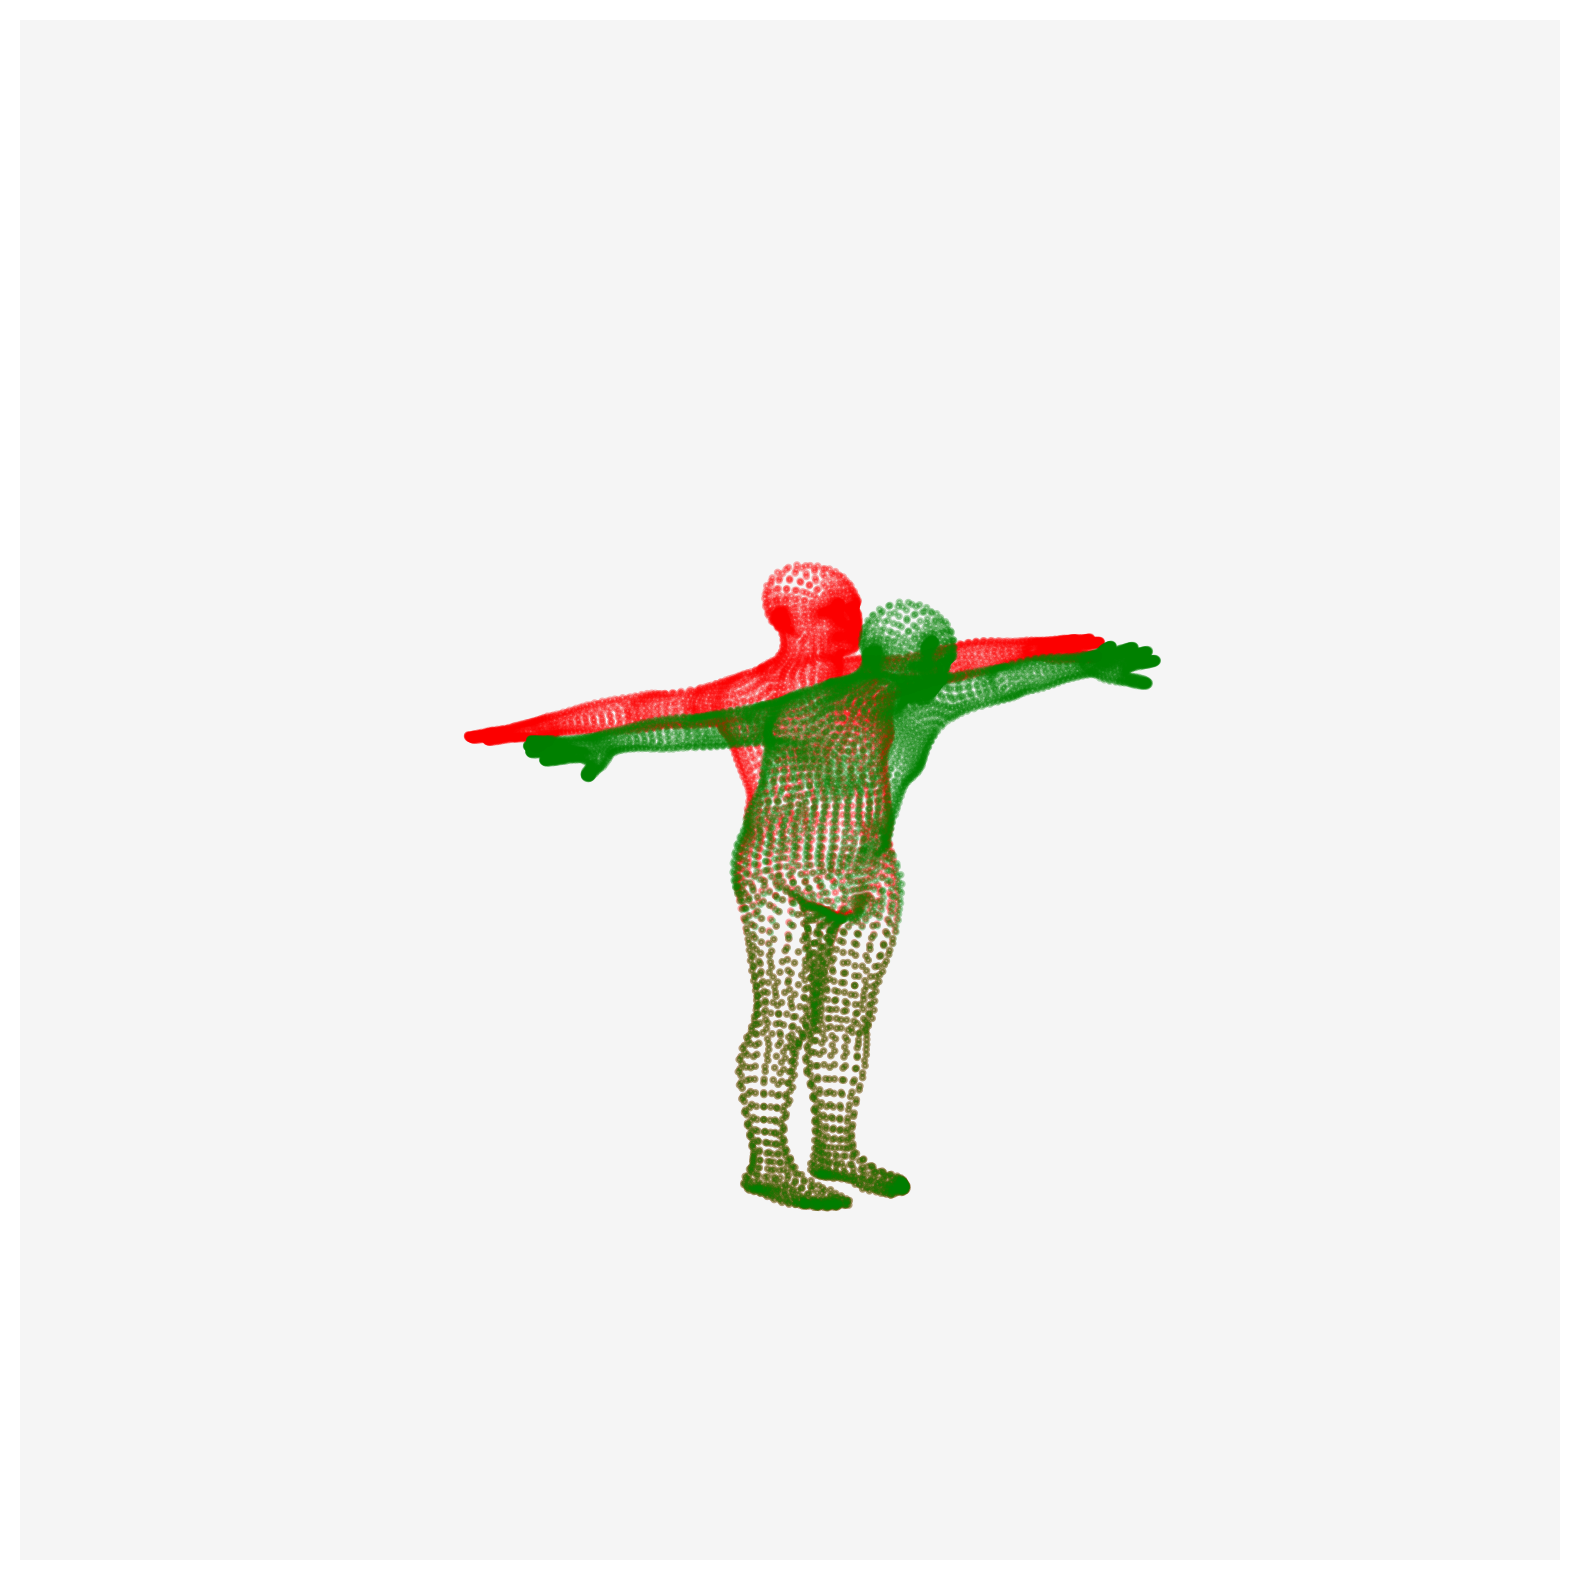

test the accuracy of the inverse of rotation and translation
the error of r$RSX_2+beta-X_1$ is 1.6618771666992936e-14
test the accuracy of the inverse of rotation and translation
the error of r$RSX_2+beta-X_1$ is 1.6618771666992936e-14
test the accuracy of the inverse of rotation and translation
the error of r$RSX_2+beta-X_1$ is 1.6618771666992936e-14
constructed point clouds


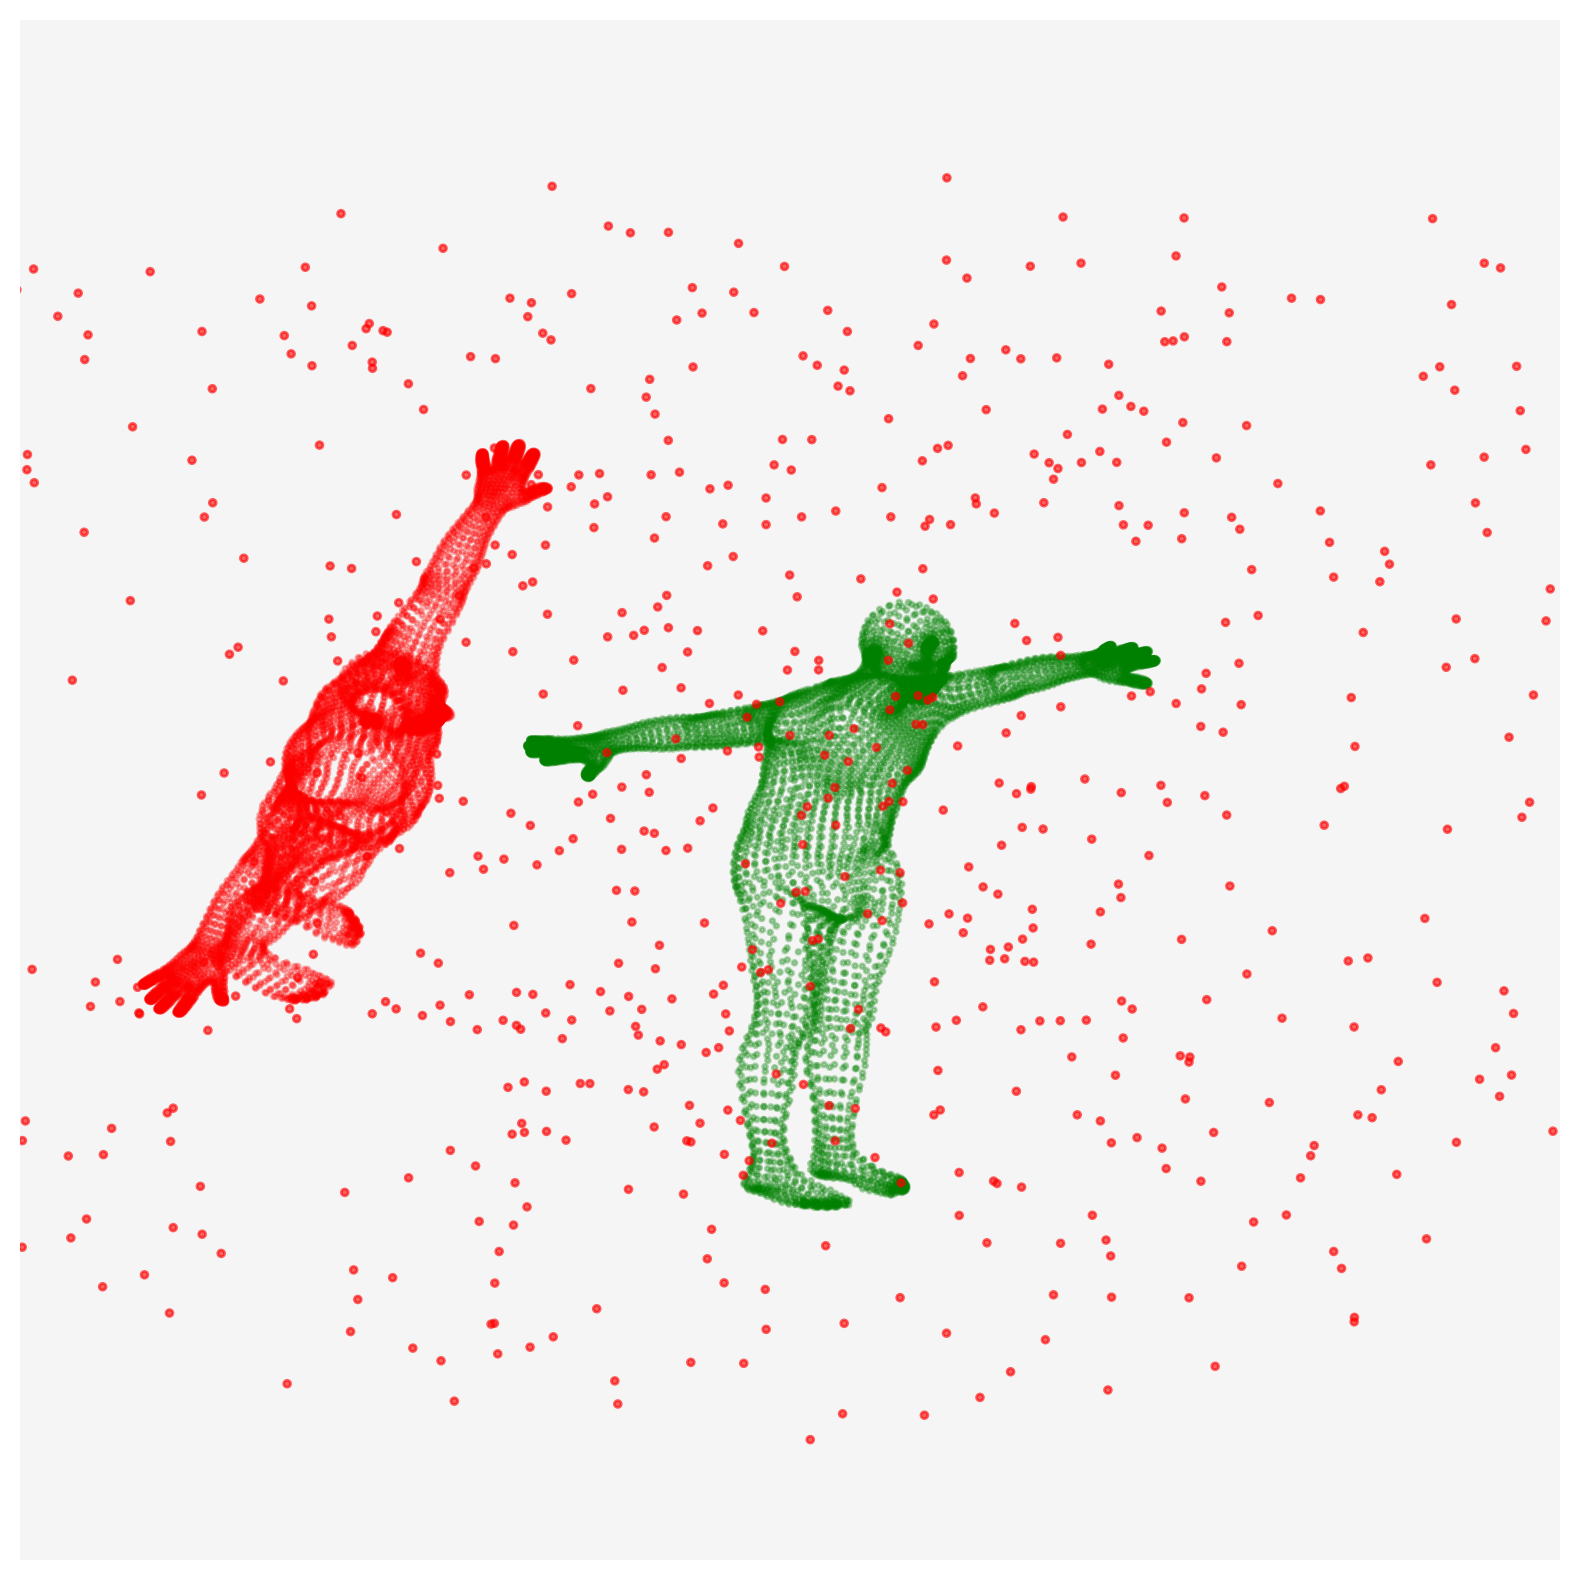

In [22]:
label,i,j='male',2,49 
# other choices in the experiment of the paper: 
#'female', 19,2 
# 'neutral', 2, 29 
data_all=torch.load('data/%s_list_noise.pt'%label)

X0=data_all['0'][i]
Y0=data_all['0'][j]
X1=data_all['0'][i]
Y1=data_all['0'][j]
print('original point clouds')
make_plot(X1,Y1,N0)
data={}
for eta in [0, 0.05,0.10]:
    X=data_all[str(eta)][i]
    Y=data_all[str(eta)][j]
    theta_0=np.array([-np.pi/6,np.pi/5,np.pi/6])
    rotation_0=rotation_in(theta_0)
    beta_0=np.array([+1.2,+0.2,-0.1])
    S_0=1.0 #0.8
    permutation=np.random.permutation(N0)
    X3=X[0:N0][permutation]
    X1=X3.dot(rotation_0)+beta_0
    X1=np.concatenate((X1,X[N0:]))
    
    theta_op=-theta_0 #np.array([np.pi/6,np.pi/4,-np.pi/5])
    rotation_op=rotation_re(theta_op)
    S_op=1/S_0
    beta_op=-S_op*beta_0.dot(rotation_op)
    X2=X1.dot(rotation_op)*S_op+beta_op
    print('test the accuracy of the inverse of rotation and translation')
    print('the error of r$RSX_2+beta-X_1$ is', np.linalg.norm(X2[0:N0]-X[0:N0][permutation]))
    data['X'+str(eta)]=X1 
    data['Y'+str(eta)]=Y
    data['permutation'+str(eta)]=permutation
    data['theta_op']=theta_op
    data['rotation_op']=rotation_op
    data['S_op']=S_op
print('constructed point clouds')
make_plot(X1,Y1,N0)


# Test the model and find the best hyperparameter. Here we apply the real correspondence.  

female_19_2
done


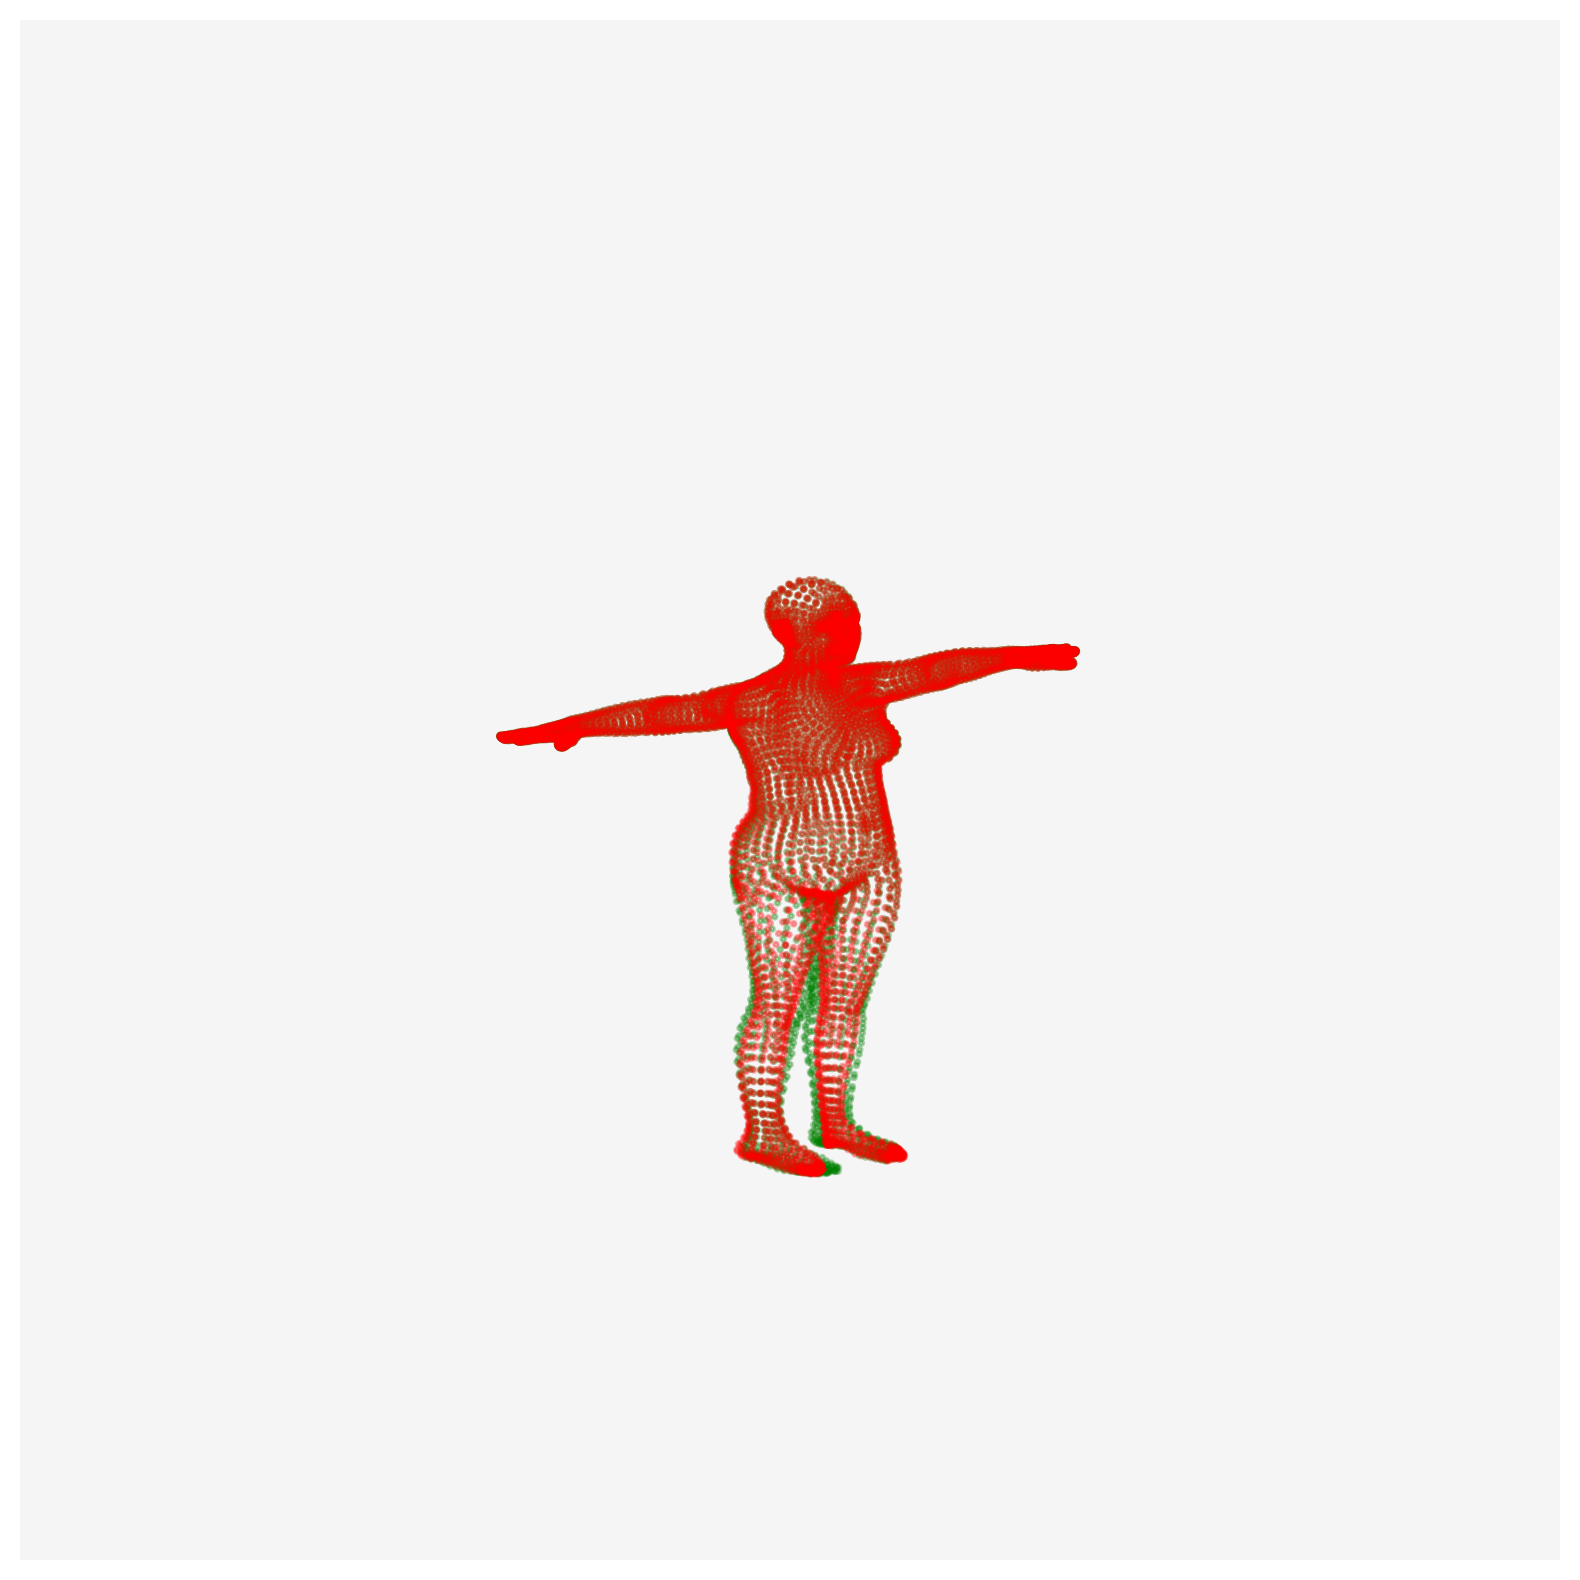

----


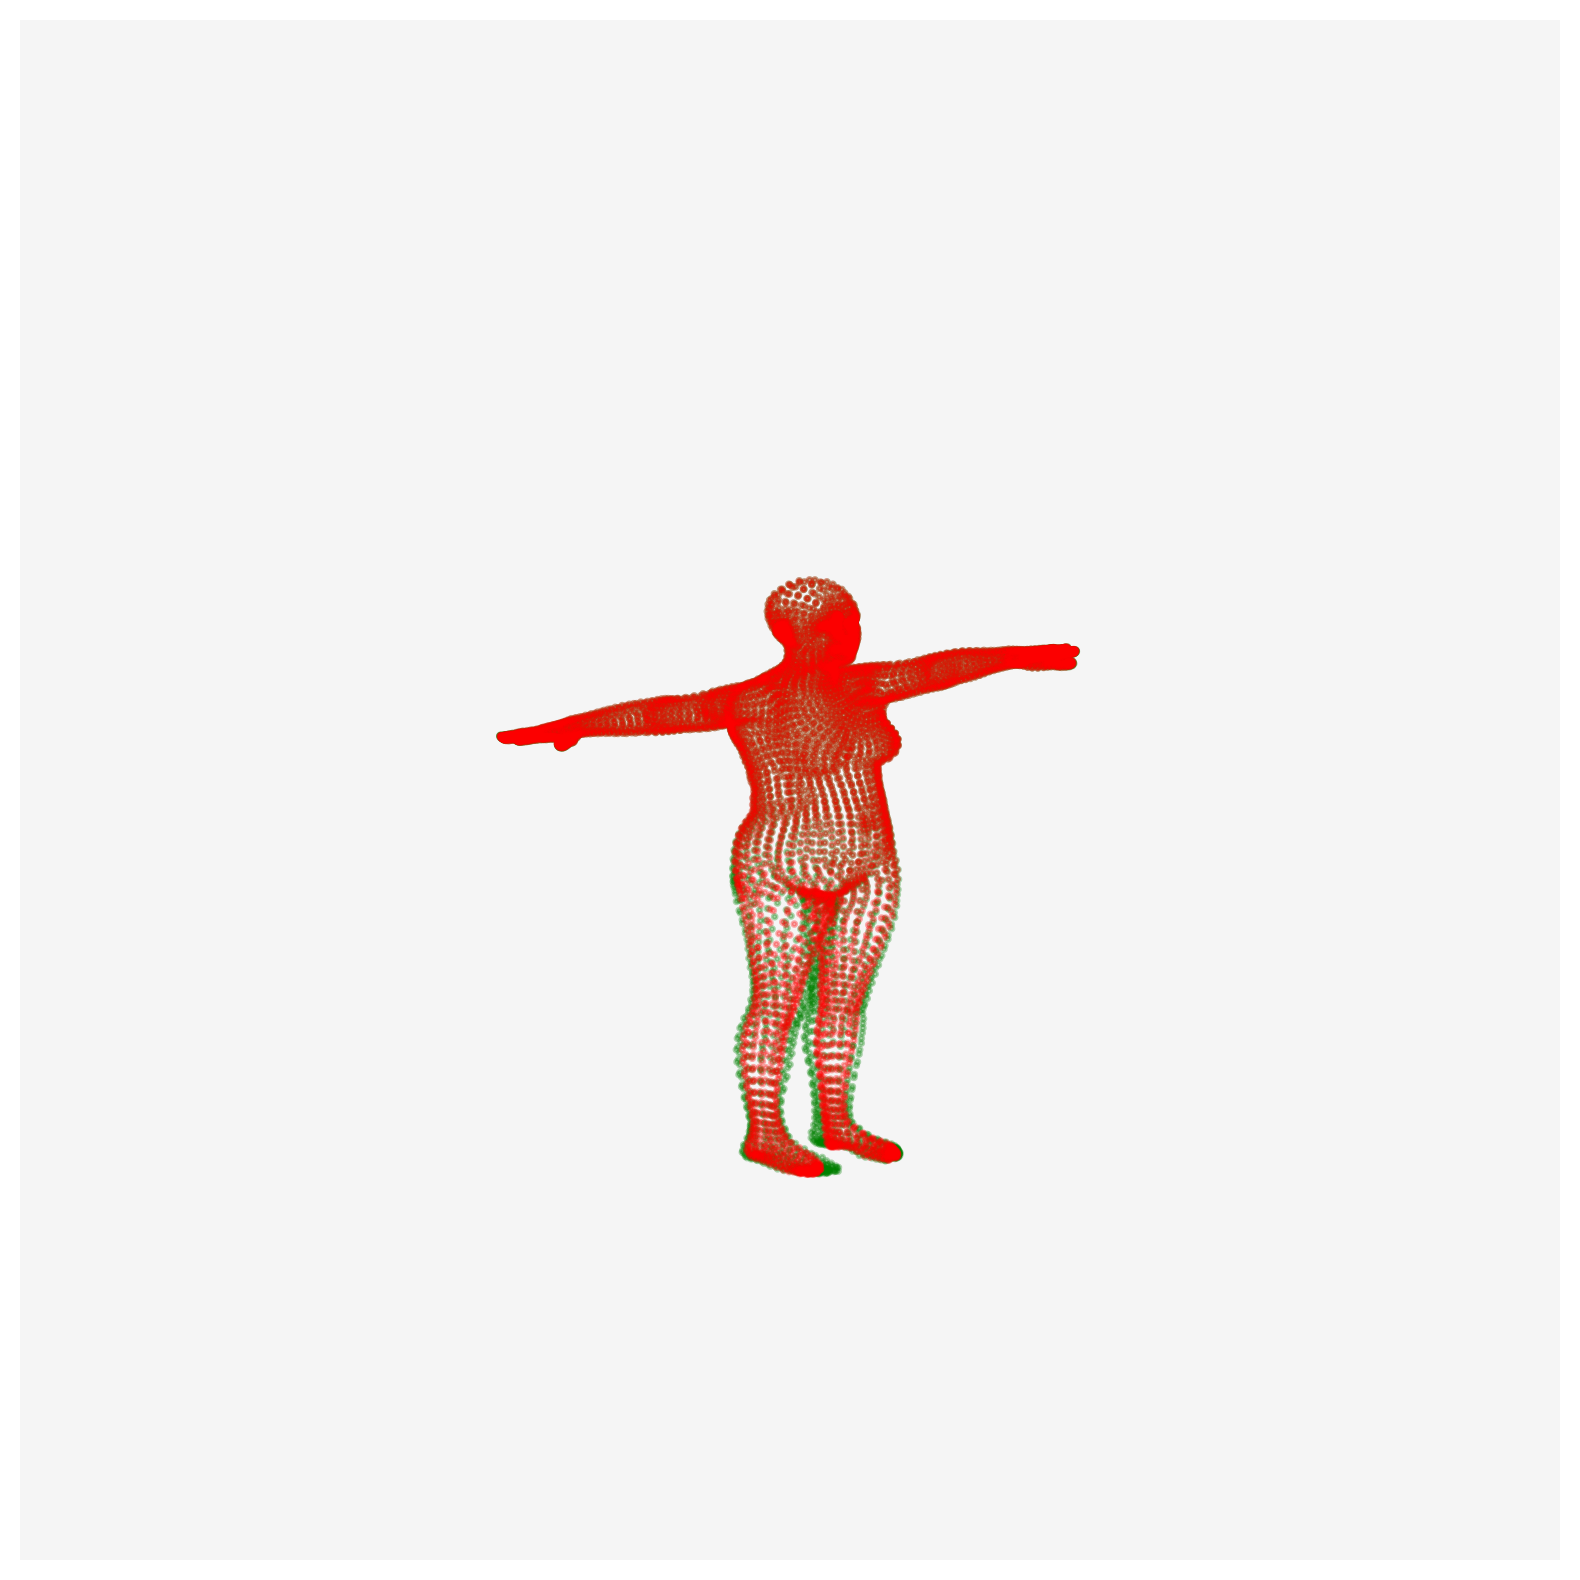

In [11]:
# test model

eta=0
label='female_19_2'  #### male_2_49, neutral_2_29
data=torch.load('data/%s.pt'%(label))
print(label)
record_index=[0,1,5,10]



X0=data['X0']
N0=X0.shape[0]
X=data['X0']
Y=data['Y0']
permutation=data['permutation%s'%eta]


sigma2=0.1
eps=1

sample_index=np.unique(np.linspace(0,N0-1,800).astype(np.int64))
C=X.copy() #[sample_index] #.copy() #[0:N0] #[sample_index] #[0:N0].copy() 
Phi=kernel_matrix_gaussian(C,X,sigma2) 
K,D=C.shape
Yhat_op=Y[permutation]

Yhat=Yhat_op.copy()
alpha=np.zeros((C.shape))
for i in range(1):
    Yprime2=Yhat-Phi.dot(alpha)
    R,S=recover_rotation(Yprime2,X)
    #make_plot(X.dot(R)+beta,Y)
    beta=vec_mean(Yprime2)-vec_mean(X.dot(R))
    Yprime1=Yhat-X.dot(R)-beta
    alpha=rbf_recover_alpha_gpu(Phi,Yprime1,eps=0.1)
    Yhat=Phi.dot(alpha)+X.dot(R)+beta
print('done')
make_plot(Yhat,Y,N0)
print('----')

Yhat=Yhat_op.copy()
Phi=kernel_matrix_tps(C,X,D=2)
X_bar=np.hstack((np.ones((X.shape[0],1)),X))
B,alpha=tps_regression(Phi,X_bar,Yhat,epsilon=0.5,device='cuda')

Yhat2=Phi.dot(alpha)+X_bar.dot(B) #Phi.dot(alpha)+X.dot(R)+beta     
make_plot(Yhat2,Y,N0)
